___Problemes de l'algo___:
- Lorsque l'on a trop de features, le calcul de runiform_ball(n, d, R) est super long. Pour une dimension de 15 (i.e. d = 15), le temps nécessaire au calcul de runiform_ball(5000, 15, R) est de <refaire la simulation mais c'est plus de 4 minutes> <-- Cette méthode de clustering en ligne ne peut pas être utilisée en grande dimension. L'idée de restreindre les centroids à une hyperball est bonne mais est très longue computationnellement quand la dimension des données augmente.

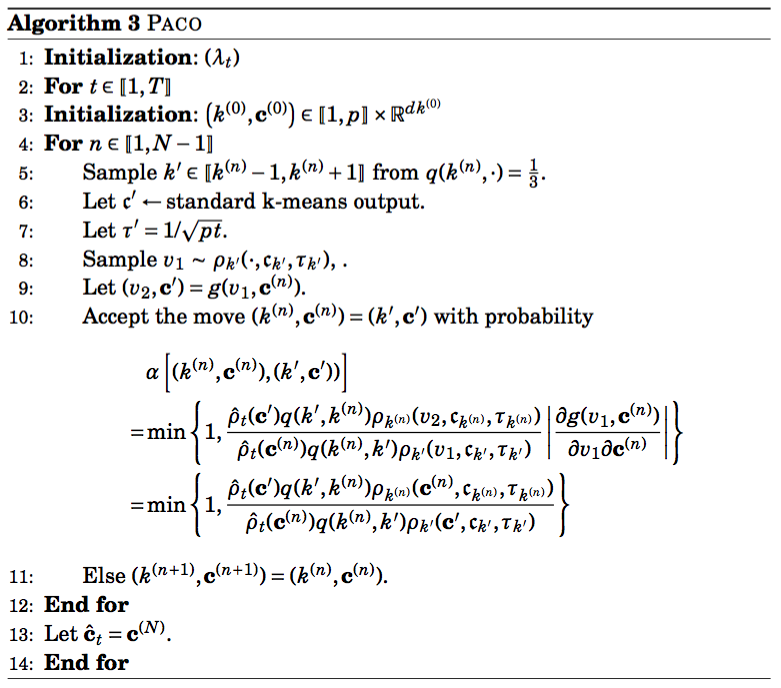

In [1]:
from IPython.display import Image
Image(filename='Algo.png')

### PACBO implementation on python

In [1]:
import pandas as pd
import numpy as np
from random import randint
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from math import *
from scipy.stats import gamma
import scipy.special as sp
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
### Funtions needed

# Student's T random variable
def multivariate_t_rvs(m, S, df=np.inf, n=1):
    '''generate random variables of multivariate t distribution
    Parameters
    ----------
    m : array_like
        mean of random variable, length determines dimension of random variable
    S : array_like
        square array of covariance  matrix
    df : int or float
        degrees of freedom
    n : int
        number of observations, return random array will be (n, len(m))
    Returns
    -------
    rvs : ndarray, (n, len(m))
        each row is an independent draw of a multivariate t distributed
        random variable
    '''
    m = np.asarray(m)
    d = len(m)
    if df == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None]   # same output format as random.multivariate_normal


def multivariate_t_distribution(x, mu, Sigma, df):
    '''
    Multivariate t-student density. Returns the density
    of the function at points specified by x.

    input:
        x = parameter (n-d numpy array; will be forced to 2d)
        mu = mean (d dimensional numpy array)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom

    Edited from: http://stackoverflow.com/a/29804411/3521179
    '''

    x = np.atleast_2d(x) # requires x as 2d
    nD = Sigma.shape[0] # dimensionality
    numerator = sp.gamma(1.0 * (nD + df) / 2.0)
    denominator = (sp.gamma(1.0 * df / 2.0) * np.power(df * np.pi, 1.0 * nD / 2.0) * np.power(np.linalg.det(Sigma), 1.0 / 2.0) * np.power(1.0 + (1.0 / df) * np.diagonal( np.dot( np.dot(x - mu, np.linalg.inv(Sigma)), (x - mu).T)), 1.0 * (nD + df) / 2.0))
    
    return 1.0 * numerator / denominator 

# Cumulative loss function
def cumulative_loss(centers, observations):
    d = observations.shape[1]
    lth_centers = len(centers)
    size_obs = len(observations)
    C_mtx = np.array([centers for i in range(size_obs)])
    Data_mtx = []
    for i in range(size_obs):
        Data_mtx.append(np.reshape(np.repeat(observations[i,:], lth_centers), newshape=(-1, lth_centers)).transpose())
    Data_mtx = np.array(Data_mtx)
    Diff = np.sum((C_mtx - Data_mtx)**2, axis=-1)
    return sum(np.min(Diff,axis = 1))

# Transition probability function
def transition_probability(x, z, K_max, prob = 1/3):
    x = int(x)
    z = int(z)
    K_max = int(K_max)
    if (x > K_max) or (z > K_max) or (x < 1) or (z < 1):
        q = 0
    elif x == 1:
        q = .5*int((z == 1) or (z == 2))
    elif x == K_max:
        q = 0.5*int((z == K_max) or (z == (K_max-1)))
    elif x == z:
        q = prob
    else:
        q = (1-prob)/2 * int(( x < z and z < (x+2)) or (z < x and z > (x-2)))
    return q

# Function to get clusters labels from centroids
def labels_function(centers, observations):
    if centers.ndim == 1:
        centers = np.matrix(centers)
    d = observations.shape[1]
    lth_centers = centers.shape[0]
    size_obs = len(observations)
    C_mtx = []
    for i in range(size_obs):
        C_mtx.append(centers)
    C_mtx = np.array(C_mtx)
    Data_mtx = []
    for i in range(size_obs):
        Data_mtx.append(np.reshape(np.repeat(observations[i,:], lth_centers), newshape=(-1, lth_centers)).transpose())
    Data_mtx = np.array(Data_mtx)
    Diff = np.sum((C_mtx - Data_mtx)**2, axis=-1)
    return np.apply_along_axis(lambda x: np.where(x==min(x)), 1, Diff).ravel()

# Function for the prior
def runiform_ball(n, d, R):
    simulations = []
    for i in range(n):
        simul = np.random.uniform(low=-R, high=R, size=d)
        while np.sqrt(sum(simul**2))>R:
            simul = np.random.uniform(low=-R, high=R, size=d)
        simulations.append(simul)
    return np.array(simulations)

# Function for the instantaneous loss
def instantaneous_loss(centers, instant_observation):
    centers = np.matrix(centers) #Delete this line
    replicate_instant_observation = np.reshape(np.matrix(np.repeat(instant_observation, len(centers))), newshape=(-1,len(centers))).transpose()
    distances = np.power(centers - replicate_instant_observation, 2).sum(axis=1)
    return np.min(distances)

In [80]:
def PACBO(X, R, coeff = 2, K_max = 50, N_iterations = 500, cluster_plot = False, axis_plot = (0,1)):
    
    d = X.shape[1]
    T = len(X)
    multiplier_R = 1.5
    sum_loss = np.repeat(0., N_iterations)
    
    # IF 
    
    nb_of_clusters = [1]
    pred_centers = []
    predicted_loss = np.repeat(0., T)
    proposal_loss = np.repeat(0., T)
    
    lambda_1 = np.array([1] + [2.5*coeff*(d+2)*(t-1)**(-0.5)/R for t in range(2,T+1)])
    lambda_2 = np.array([(d+2)*(t)**(-0.5)/(multiplier_R * R)**4 for t in range(1,T+1)])
    
    c_1 = runiform_ball(5000, d, multiplier_R*R)
    
    index_1 = np.array(np.power(c_1 - np.reshape(np.matrix(np.repeat(X[0], 5000)), newshape=(-1,5000)).transpose(), 2).sum(axis=1)).ravel()
    index_1 = np.where(index_1 == instantaneous_loss(c_1, X[0]))[0][0]
    pred_centers.append(c_1[index_1])
    predicted_loss[0] = instantaneous_loss(pred_centers[0], X[0])
    
    for t in range(2,T+1): # t va de 2 à 10
        parameter_means_proposal = []
        Niter_centers = []
        Nclusters = []
        
        tau_proposal = (K_max*t*d)**(-0.5)
        
        Nclusters.append(nb_of_clusters[t-2])
        kmeans = KMeans(n_clusters=Nclusters[0], random_state=0, max_iter=10).fit(X[:t-1])
        parameter_means_proposal.append(kmeans.cluster_centers_)
        
        Niter_centers.append(np.apply_along_axis(lambda x: multivariate_t_rvs(x, np.diag([tau_proposal for i in range(d)]), df=3, n=1)[0], 1, parameter_means_proposal[0]))

        while sum(np.sqrt(np.sum(np.power(Niter_centers[0],2),axis = 1)) > multiplier_R * R) > 0:
            Niter_centers[0] = np.apply_along_axis(lambda x: multivariate_t_rvs(x, np.diag([tau_proposal for i in range(d)]), df=3, n=1)[0], 1, parameter_means_proposal[0])


        proposal_loss[:t-1] = list(np.apply_along_axis(lambda x: instantaneous_loss(Niter_centers[0], x), 1, X[:t-1]))
        
        sum_loss[0] = sum(proposal_loss[:(t-1)]) + 0.5 * sum(lambda_2 * (proposal_loss - predicted_loss)**2)
        
        for n in range(2,N_iterations+1): # n va de 2 à 500
            proposal_loss_temp = np.repeat(0., T)
            transition_prob = np.array([transition_probability(Nclusters[n-2],Nclusters[n-2]-1,K_max), transition_probability(Nclusters[n-2],Nclusters[n-2],K_max), transition_probability(Nclusters[n-2],Nclusters[n-2]+1,K_max)])
            transition_prob = transition_prob/sum(transition_prob)
            new_k = np.random.choice([Nclusters[n-2]-1,Nclusters[n-2],Nclusters[n-2]+1], p=transition_prob)
            
            if new_k == Nclusters[n-2]:
                m_t = parameter_means_proposal[n-2]
            else:
                if new_k >= t-1:
                    new_k = t-1
                    m_t = X[:t-1]
                else:
                    kmeans = KMeans(n_clusters=int(new_k), random_state=0, max_iter=10).fit(X[:t-1])
                    m_t = kmeans.cluster_centers_
            c_k_prime = np.apply_along_axis(lambda x: multivariate_t_rvs(x, np.diag([tau_proposal for i in range(d)]), df=3, n=1), 1, m_t)
            
            if sum(np.sqrt(np.sum(c_k_prime**2, axis = 2)) < multiplier_R * R ) == new_k: 
                log_numerator_prop = np.array([np.log(multivariate_t_distribution(Niter_centers[n-2][x,], parameter_means_proposal[n-2][x,], np.diag([tau_proposal for i in range(d)]), 3)) for x in range(Nclusters[n-2])])
                log_denominator_prop = np.array([np.log(multivariate_t_distribution(c_k_prime[x,], m_t[x,], np.diag([tau_proposal for i in range(d)]), 3)) for x in range(new_k)])    
                
                log_numerator_prior = np.repeat(log(sp.gamma(d/2+1)) - (d/2)*np.log(pi) - d*np.log(multiplier_R*R),new_k)
                log_denominator_prior = np.repeat(log(sp.gamma(d/2+1)) - (d/2)*np.log(pi) - d*np.log(multiplier_R*R),Nclusters[n-2])
                
                ln_division = sum(np.concatenate((log_numerator_prior, log_numerator_prop.ravel())) - np.concatenate((log_denominator_prior, log_denominator_prop.ravel())))
                
                proposal_loss_temp[:t-1] = list(np.apply_along_axis(lambda x: instantaneous_loss(c_k_prime, x), 1, X[:t-1]))
                
                s_loss_prime = sum(proposal_loss_temp) + .5 * sum(lambda_2 * (proposal_loss_temp - predicted_loss)**2)
                
                ln_accept_ratio = (-lambda_1[t-2] * (s_loss_prime-sum_loss[n-2])) + ln_division + np.log(transition_probability(new_k, Nclusters[n-2],K_max)) - np.log(transition_probability(Nclusters[n-2], new_k, K_max))
            else:
                ln_accept_ratio = float('-inf')
            
            bool_ = np.log(np.random.uniform()) < ln_accept_ratio
            
            if bool_:
                Niter_centers.append(np.array(np.matrix(c_k_prime)))
                parameter_means_proposal.append(m_t)
                Nclusters.append(new_k)
                sum_loss[n-1] = s_loss_prime
            else:
                Niter_centers.append(Niter_centers[n-2])
                parameter_means_proposal.append(parameter_means_proposal[n-2])
                Nclusters.append(Nclusters[n-2])
                sum_loss[n-1] = sum_loss[n-2]
        
        nb_of_clusters.append(Nclusters[N_iterations-1])
        pred_centers.append(np.matrix(Niter_centers[N_iterations-1]))
        predicted_loss[t-1] = instantaneous_loss(pred_centers[t-2], X[t-1,])
        
        if cluster_plot:
        # Plot clusters
            plt.scatter(X[:t,axis_plot[0]],X[:t,axis_plot[1]], c=[matplotlib.cm.spectral(float(i) /10) for i in labels_function(pred_centers[t-1], X[:t,:])])
            plt.scatter(np.array(pred_centers[t-1][:,axis_plot[0]]),np.array(pred_centers[t-1][:,axis_plot[1]]), marker="2", c = "green")
            plt.show()
            
    labels = labels_function(pred_centers[T-1], X)
    
    return [nb_of_clusters[T-1], pred_centers[T-1], labels]

In [81]:
# The X we will use is
data = pd.read_csv('test.csv')
data = data.drop(['Unnamed: 0'], axis = 1)
X = data.as_matrix()
R = np.max(np.sqrt(np.sum(X**2, axis=1)))

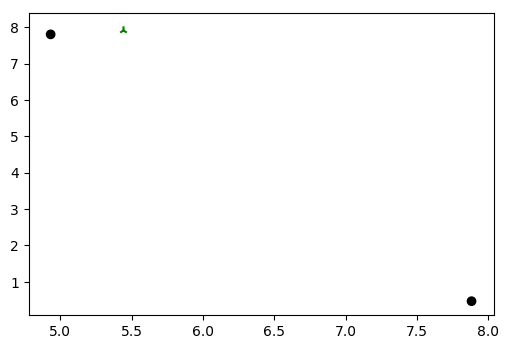

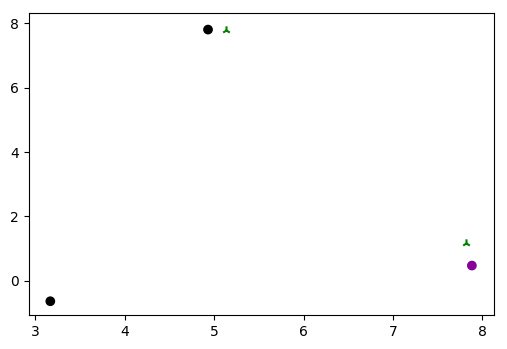

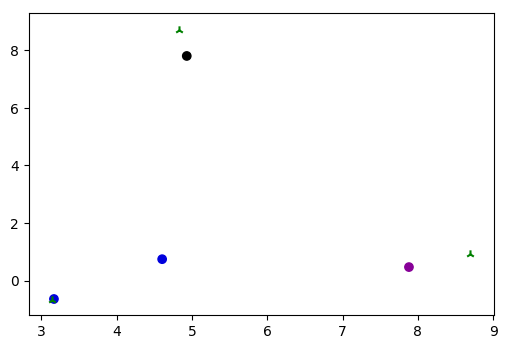

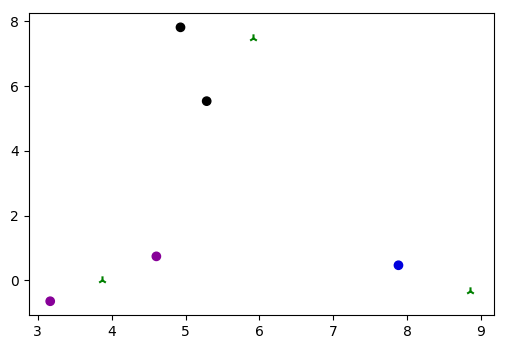

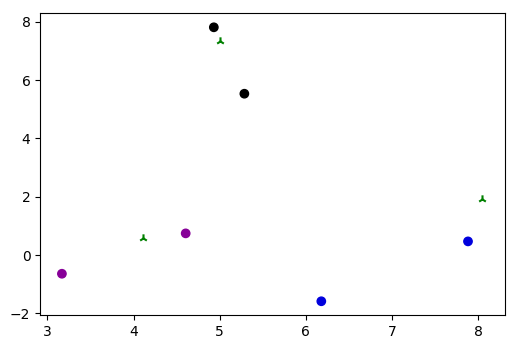

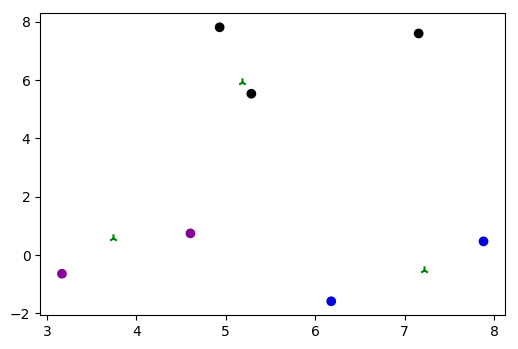

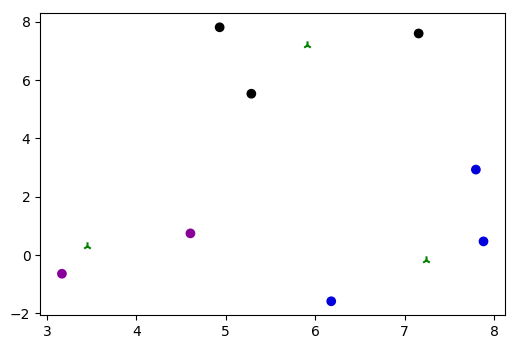

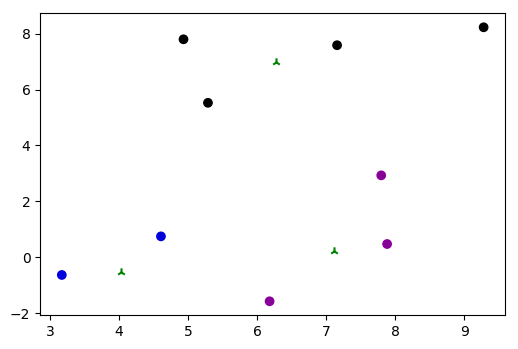

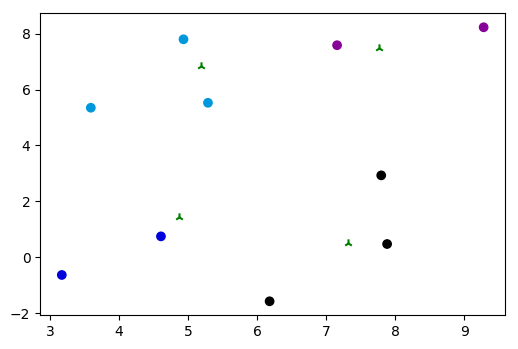

[4, matrix([[  7.31602162,   0.48963513,  -8.87164641,   1.76474455,
            5.52747778],
         [  7.76253106,   7.49146231,   3.26802079,  10.19776514,
           -2.82766088],
         [  4.86523057,   1.43133654,   9.29806124,   8.57213484,
           -2.63701156],
         [  5.18292173,   6.83671884,   0.40143563,   5.39477734,
           -2.89589708]]), array([3, 0, 2, 2, 3, 0, 1, 0, 1, 3])]

In [82]:
PACBO(X, R, coeff = 2, K_max = 50, N_iterations = 500, cluster_plot = True, axis_plot = (0,1))